# 第七章

## AdaGrad算法

需要注意的是，AdaGrad算法要对每个自变量维护同它一样形状的状态变量。

这部分代码导入了所需的库，包括torch（PyTorch深度学习框架）、torch.nn（PyTorch的神经网络库）、torch.nn.functional（包含许多函数，可以用于构建神经网络的层）、matplotlib.pyplot（用于数据可视化）等。

In [1]:
# 导入需要的工具包导入库：
# 这部分代码导入了所需的库，包括torch（PyTorch深度学习框架）、torch.nn（PyTorch的神经网络库）、
# torch.nn.functional（包含许多函数，可以用于构建神经网络的层）、matplotlib.pyplot（用于数据可视化）等。
import torch
from torch import nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline
from d2l import torch as d2l
from sklearn.datasets import load_iris
from torchvision.io import read_image
from torch.utils.data import Dataset, DataLoader


Bad key "text.kerning_factor" on line 4 in
d:\conda\envs\DL\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


定义模型：这部分代码定义了一个前馈神经网络模型，包括两个全连接层和一个Sigmoid激活函数。这个模型可以用于二分类问题，例如判断邮件是否为垃圾邮件、判断图片是否包含某个物体等。

In [2]:
class FeedForward(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):      #定义一个名为FeedForward的类，它继承自nn.Module类
        super(FeedForward,self).__init__()                         #定义类的初始化函数，接收三个参数：输入层大小（input_size）、隐藏层大小（hidden_size）和输出层大小（output_size）
        self.fc1 = nn.Linear(input_size, hidden_size)              #调用父类nn.Module的初始化函数
        self.fc2 = nn.Linear(hidden_size, output_size)             #定义第一个全连接层，接收input_size个输入，输出hidden_size个输出
        self.act = nn.Sigmoid()                                    #定义第二个全连接层，接收hidden_size个输入，输出output_size个输出
                                                                   # 定义Sigmoid激活函数
    def forward(self, inputs):                                     #定义前向传播函数，接收一个参数inputs，表示输入数据
        outputs = self.fc1(inputs)                                 #将输入数据传入第一个全连接层，得到输出outputs
        outputs = self.act(outputs)                                #将上一步的输出通过Sigmoid激活函数，得到新的outputs
        outputs = self.fc2(outputs)                                #将上一步的输出传入第二个全连接层，得到新的outputs
        return outputs                                             #返回最终的输出

这段代码定义了AdaGrad优化算法的初始化状态函数和更新函数。AdaGrad算法是一种自适应学习率的优化算法，它可以根据参数的历史梯度信息来调整学习率，使得每个参数都有自己的学习率。这对于稀疏数据和非均匀分布的数据非常有用。

In [3]:
#这个函数用于初始化AdaGrad算法的状态。它接收一个参数feature_dim，表示特征的维度
# 函数返回两个全零张量s_w和s_b，它们的形状分别为(feature_dim, 3)和3，用于存储权重和偏置的累积平方梯度
def init_adagrad_states(feature_dim):                                
    s_w = torch.zeros((feature_dim, 3))
    s_b = torch.zeros(3)
    return (s_w, s_b)

#这个函数用于更新AdaGrad算法的参数。它接收三个参数：params（需要更新的参数列表）、states（参数的状态，即累积平方梯度）和hyperparams（超参数，包括学习率）
def adagrad(params, states, hyperparams):
    eps = 1e-6                                             #这是一个非常小的数，用于防止除数为零
    for p, s in zip(params, states):
        with torch.no_grad():
            s[:] += torch.square(p.grad)
            p[:] -= hyperparams['lr'] * p.grad / torch.sqrt(s + eps)
        p.grad.data.zero_()                                #清零参数p的梯度，为下一次迭代做准备

这段代码定义了两个函数：evaluate_loss和train.这段代码使用了d2l库，这是一个用于深度学习的教学库，提供了一些实用的函数和类，如d2l.linreg（线性回归）、d2l.reduce_sum（求和）、d2l.size（求大小）、d2l.Timer（计时器）和d2l.Animator（动画制作）等。

In [4]:
#这个函数用于评估给定数据集上模型的损失。它接收三个参数：net（模型）、data_iter（数据迭代器）和loss（损失函数）。函数计算并返回数据集上的平均损失
def evaluate_loss(net, data_iter, loss):
    metric = d2l.Accumulator(2)                  # 损失的总和,样本数量
    for X, y in data_iter:
        X = X.to(torch.float32)
        out = net(X)
#         y = d2l.reshape(y, out.shape)
        l = loss(out, y.long())
        metric.add(d2l.reduce_sum(l), d2l.size(l))
    return metric[0] / metric[1]


"""这个函数用于训练模型。它接收六个参数：trainer_fn（优化算法的更新函数）、states（优化算法的状态）、hyperparams（超参数，包括学习率）、data_iter（数据迭代器）、feature_dim（特征的维度）和num_epochs（训练的轮数，默认为2）

函数首先初始化模型的参数w和b，然后定义模型net和损失函数loss。

- 然后，函数进入训练的主循环，对于每一轮，对于数据迭代器中的每一批数据，计算损失，进行反向传播，然后使用优化算法的更新函数更新参数。

- 在每一轮结束时，函数使用evaluate_loss函数计算并打印当前的平均损失"""
def train(trainer_fn, states, hyperparams, data_iter, feature_dim, num_epochs=2):
    """Defined in :numref:`sec_minibatches`"""
    # 初始化模型
    w = torch.normal(mean=0.0, std=0.01, size=(feature_dim, 3),
                     requires_grad=True)
    b = torch.zeros((3), requires_grad=True)
    # 训练模型
    animator = d2l.Animator(xlabel='epoch', ylabel='loss',
                            xlim=[0, num_epochs], ylim=[0.9, 1.1])
    n, timer = 0, d2l.Timer()
    
    # 这是一个单层线性层     
    net = lambda X: d2l.linreg(X, w, b)
    loss = F.cross_entropy 
    for _ in range(num_epochs):
        for X, y in data_iter:
            X = X.to(torch.float32)
            l = loss(net(X), y.long()).mean()
            l.backward()
            trainer_fn([w, b], states, hyperparams)
            n += X.shape[0]
            if n % 48 == 0:
                timer.stop()
                animator.add(n/X.shape[0]/len(data_iter),
                             (evaluate_loss(net, data_iter, loss),))
                timer.start()
    print(f'loss: {animator.Y[0][-1]:.3f}, {timer.avg():.3f} sec/epoch')

    return timer.cumsum(), animator.Y[0]

这段代码定义了一个名为IrisDataset的数据集类，用于加载和处理鸢尾花数据集。这个类继承自PyTorch的Dataset类,可以用于PyTorch的DataLoader，方便地进行批量数据的读取和处理。

In [5]:
from torch.utils.data import Dataset, DataLoader

def load_data(shuffle=True):
    x = torch.tensor(load_iris().data)
    y = torch.tensor(load_iris().target)
    
    # 数据归一化
    x_min = torch.min(x, dim=0).values
    x_max = torch.max(x, dim=0).values
    x = (x-x_min)/(x_max-x_min)
    
    if shuffle:
        idx = torch.randperm(x.shape[0])
        x = x[idx]
        y = y[idx]
    return x, y


class IrisDataset(Dataset):
    def __init__(self, mode='train', num_train=120, num_dev=15):     #定义类的初始化函数，接收三个参数：mode（模式，可以是'train'、'dev'或'test'）、num_train（训练集的大小）和num_dev（验证集的大小
        super(IrisDataset,self).__init__()
        x, y = load_data(shuffle=True)                               #个函数用于加载鸢尾花数据集，并对数据进行归一化处理。如果shuffle参数为True，则会对数据进行随机打乱
        if mode == 'train':
            self.x, self.y = x[:num_train], y[:num_train]
        elif mode == 'dev':
            self.x, self.y = x[num_train:num_train + num_dev], y[num_train:num_train + num_dev]
        else:
            self.x, self.y = x[num_train + num_dev:], y[num_train + num_dev:]
    
    
    #定义获取数据的函数，接收一个参数idx，返回对应索引的数据和标签
    def __getitem__(self, idx): 
        return self.x[idx], self.y[idx]
    
    
    #定义获取数据集大小的函数，返回数据的数量
    def __len__(self):
        return len(self.x)

In [6]:
# batch_size = 1
batch_size = 24
# batch_size = 120 

# 分别构建训练集、验证集和测试集
train_dataset = IrisDataset(mode='train')

train_loader = DataLoader(train_dataset, batch_size=batch_size,shuffle=True)

loss: 1.031, 0.003 sec/epoch


([0.005997180938720703,
  0.005997180938720703,
  0.008997440338134766,
  0.011996030807495117,
  0.014995336532592773],
 [1.072552227973938,
  1.056186842918396,
  1.045657753944397,
  1.0377350091934203,
  1.0310017347335816])

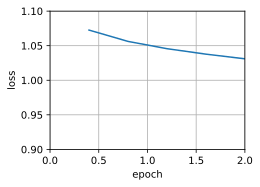

In [7]:
lr = 0.02
train(adagrad, init_adagrad_states(4), {'lr':lr}, train_loader, 4)

## RMSProp算法

这段代码定义了RMSProp优化算法的初始化状态函数和更新函数，RMSProp算法是一种自适应学习率的优化算法，它可以根据参数的历史梯度信息来调整学习率，使得每个参数都有自己的学习率。这对于稀疏数据和非均匀分布的数据非常有用。

In [8]:

#这个函数用于初始化RMSProp算法的状态。它接收一个参数feature_dim，表示特征的维度。函数返回两个全零张量s_w和s_b，它们的形状分别为(feature_dim, 3)和3，用于存储权重和偏置的移动平均平方梯度
def init_rmsprop_states(feature_dim):
    s_w = torch.zeros((feature_dim, 3))
    s_b = torch.zeros(3)
    return (s_w, s_b)


#这个函数用于更新RMSProp算法的参数。它接收三个参数：params（需要更新的参数列表）、states（参数的状态，即移动平均平方梯度）和hyperparams（超参数，包括学习率和衰减率）
def rmsprop(params, states, hyperparams):
    gamma, eps = hyperparams['gamma'], 1e-6
    for p, s in zip(params, states):
        with torch.no_grad():
            s[:] = gamma * s + (1 - gamma) * torch.square(p.grad)                     #更新状态s，计算参数p的梯度的平方的移动平均
            p[:] -= hyperparams['lr'] * p.grad / torch.sqrt(s + eps)                  #更新参数p，使用RMSProp算法的更新规则
        p.grad.data.zero_()

loss: 0.909, 0.002 sec/epoch


([0.0029997825622558594,
  0.005007028579711914,
  0.00800943374633789,
  0.010051727294921875,
  0.010051727294921875],
 [1.0233955144882203,
  0.9833118438720703,
  0.957673192024231,
  0.9346113324165344,
  0.9093268513679504])

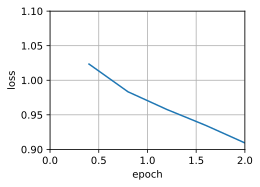

In [9]:
lr = 0.02
train(rmsprop, init_rmsprop_states(4), {'lr':lr, 'gamma':0.9}, train_loader, 4)

## Adam算法 （此代码块为作业）


这段代码定义了Adam优化算法的初始化状态函数和更新函数，Adam算法是一种自适应学习率的优化算法，它可以根据参数的历史梯度信息来调整学习率，使得每个参数都有自己的学习率。这对于稀疏数据和非均匀分布的数据非常有用。

In [10]:
#这个函数用于初始化Adam算法的状态。它接收一个参数feature_dim，表示特征的维度。函数返回四个全零张量v_w、v_b、s_w和s_b，它们的形状分别为(feature_dim, 3)和3，用于存储权重和偏置的一阶矩估计（移动平均）和二阶矩估计（移动平方平均）
def init_adam_states(feature_dim):
    v_w, v_b = torch.zeros((feature_dim, 3)), torch.zeros(3)
    s_w, s_b = torch.zeros((feature_dim, 3)), torch.zeros(3)
    return ((v_w, s_w), (v_b, s_b))



#这个函数用于更新Adam算法的参数。它接收三个参数：params（需要更新的参数列表）、states（参数的状态，即一阶矩估计和二阶矩估计）和hyperparams（超参数，包括学习率和时间步）
def adam(params, states, hyperparams):
    beta1, beta2, eps = 0.9, 0.999, 1e-6                    #这是Adam算法的超参数，包括一阶矩估计的衰减率beta1、二阶矩估计的衰减率beta2和一个非常小的数eps，用于防止除数为零
    for p, (v, s) in zip(params, states):
        with torch.no_grad():
            v[:] = beta1 * v + (1 - beta1) * p.grad
            s[:] = beta2 * s + (1 - beta2) * torch.square(p.grad)
            v_bias_corr = v / (1 - beta1 ** hyperparams['t'])
            s_bias_corr = s / (1 - beta2 ** hyperparams['t'])
            p[:] -= hyperparams['lr'] * v_bias_corr / (torch.sqrt(s_bias_corr)+ eps)
        p.grad.data.zero_()
    hyperparams['t'] += 1

loss: 0.984, 0.001 sec/epoch


([0.0,
  0.0,
  0.0030007362365722656,
  0.0050313472747802734,
  0.007071256637573242],
 [1.0719010829925537,
  1.0473102807998658,
  1.024393916130066,
  1.0038854002952575,
  0.9841358542442322])

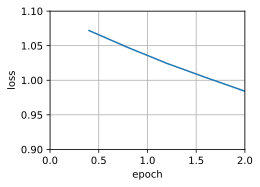

In [11]:
lr = 0.02
train(adam, init_adam_states(4), {'lr':lr, 't':1}, train_loader, 4)

## 简洁实现

深度学习框架中已经实现了Adam算法。\
我们实例化一个Adam类, 并将参数设置为对应的形式即可。 

这段代码定义了一个名为Runner的类，用于管理模型的训练、验证、预测和保存，使得代码更加清晰和易于理解。

In [12]:
class Runner(object):
    #初始化函数，接收模型、优化器、损失函数和评价指标作为参数。
    def __init__(self, model, optimizer, loss_fn, metric=None, **kwargs):
        self.model = model
        self.optimizer = optimizer
        self.loss_fn = loss_fn
        # 用于计算评价指标
        self.metric = metric
        
        # 记录训练过程中的评价指标变化
        self.dev_scores = []
        # 记录训练过程中的损失变化
        self.train_step_losses = []
        self.dev_losses = []
        # 记录全局最优评价指标
        self.best_score = 0
   
 
# 模型训练阶段，训练函数，接收训练数据加载器和验证数据加载器作为参数。在训练过程中，每个epoch结束后，如果设置了验证步骤，会进行一次验证，并保存最佳模型
    def train(self, train_loader, dev_loader=None, **kwargs):
        # 将模型设置为训练模式，此时模型的参数会被更新
        self.model.train()
        
        num_epochs = kwargs.get('num_epochs', 0)
        log_steps = kwargs.get('log_steps', 100)
        save_path = kwargs.get('save_path','final_model.pth')
        eval_steps = kwargs.get('eval_steps', 0)
        # 运行的step数，不等于epoch数
        global_step = 0
        
        if eval_steps:
            if dev_loader is None:
                raise RuntimeError('Error: dev_loader can not be None!')
            if self.metric is None:
                raise RuntimeError('Error: Metric can not be None')
                
        # 遍历训练的轮数
        for epoch in range(num_epochs):
            total_loss = 0
            # 遍历数据集
            for step, data in enumerate(train_loader):
                x, y = data
                logits = self.model(x.float())
                loss = self.loss_fn(logits, y.long())
                total_loss += loss
                if log_steps and global_step%log_steps == 0:
                    print(f'loss:{loss.item():.5f}')
                    
                loss.backward()
                self.optimizer.step()
                self.optimizer.zero_grad()
                global_step += 1
                # 保存当前轮次训练损失的累计值
                self.train_step_losses.append((global_step,loss.item()))
                
            # 每隔一定轮次进行一次验证，由eval_steps参数控制，可以采用不同的验证判断条件
            if eval_steps:
                if (epoch+1)% eval_steps ==  0:

                    dev_score, dev_loss = self.evaluate(dev_loader, global_step=global_step)
                    print(f'[Evalute] dev score:{dev_score:.5f}, dev loss:{dev_loss:.5f}')
                
                    if dev_score > self.best_score:
                        self.save_model(f'model_{epoch+1}.pth')
                    
                        print(f'[Evaluate]best accuracy performance has been updated: {self.best_score:.5f}-->{dev_score:.5f}')
                        self.best_score = dev_score
                    
                # 验证过程结束后，请记住将模型调回训练模式   
                    self.model.train()
            

            
        self.save_model(save_path) 
        print('[Train] Train done')
      
    # 模型评价阶段，验证函数，接收验证数据加载器作为参数。在验证过程中，计算并返回验证集上的评价指标和损失
    def evaluate(self, dev_loader, **kwargs):
        assert self.metric is not None
        # 将模型设置为验证模式，此模式下，模型的参数不会更新
        self.model.eval()
        global_step = kwargs.get('global_step',-1)
        total_loss = 0
        self.metric.reset()
        
        for batch_id, data in enumerate(dev_loader):
            x, y = data
            logits = self.model(x.float())
            loss = self.loss_fn(logits, y.long()).item()
            total_loss += loss 
            self.metric.update(logits, y)
            
        dev_loss = (total_loss/len(dev_loader))
        self.dev_losses.append((global_step, dev_loss))
        dev_score = self.metric.accumulate()
        self.dev_scores.append(dev_score)
        return dev_score, dev_loss
    
    # 模型预测阶段，预测函数，接收输入数据x作为参数，返回模型的预测结果
    def predict(self, x, **kwargs):
        self.model.eval()
        logits = self.model(x)
        return logits
    
    # 保存模型的参数，保存模型函数，接收保存路径作为参数，将模型的参数保存到指定路径
    def save_model(self, save_path):
        torch.save(self.model.state_dict(),save_path)
        
    # 读取模型的参数，加载模型函数，接收模型路径作为参数，从指定路径加载模型的参数
    def load_model(self, model_path):
        self.model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))

使用第四章定义的可视化函数,观察不同超参数设置下的实验结果

函数首先创建一个图像，然后在第一个子图中绘制训练和验证损失的变化，然后在第二个子图中绘制验证评价指标的变化。最后，将绘制的图像保存到指定的文件.

In [13]:
"""以下是每个参数的详细解释：

1. runner: 这是一个Runner对象，包含了训练过程中的损失和评价指标的记录。

2. fig_name: 这是保存图像的文件名。

3. fig_size: 这是图像的大小，默认为(16, 6)。

4. sample_step: 这是采样步长，用于从训练损失中采样数据，默认为20。

5. loss_legend_loc和acc_legend_loc: 这是损失和评价指标图例的位置，默认分别为'upper right'和'lower right'。

6. train_color和dev_color: 这是训练和验证曲线的颜色，默认分别为'#8E004D'和'#E20079'。

7. fontsize: 这是字体大小，默认为'x-large'。

8. train_linestyle和dev_linestyle: 这是训练和验证曲线的线型，默认分别为'-'和'--'。"""
def plot_training_loss_acc(runner, fig_name, fig_size=(16, 6), sample_step=20, loss_legend_loc='upper right', acc_legend_loc='lower right',
                          train_color = '#8E004D', dev_color = '#E20079', fontsize='x-large', train_linestyle='-', dev_linestyle='--'):
    plt.figure(figsize=fig_size)
    plt.subplot(1,2,1)
    train_items = runner.train_step_losses[::sample_step]
    train_steps = [x[0] for x in train_items]
    train_losses = [x[1] for x in train_items]
    oc=acc_legend_loc
    # 将绘制结果保存
    plt.savefig(fig_name)
    plt.show()

    plt.plot(train_steps, train_losses, color=train_color, linestyle=train_linestyle, label='Train loss')
    if len(runner.dev_losses) > 0:
        dev_steps = [x[0] for x in runner.dev_losses]
        dev_losses = [x[1] for x in runner.dev_losses]
        plt.plot(dev_steps, dev_losses, color=dev_color, linestyle=dev_linestyle,label='dev loss')
    
    plt.ylabel('loss')
    plt.xlabel('step')
    plt.legend(loc=loss_legend_loc)
    if len(runner.dev_scores) > 0:
        plt.subplot(1,2,2)
        plt.plot(dev_steps, runner.dev_scores, color=dev_color, linestyle=dev_linestyle, label='dev accuracy')
        
        plt.ylabel('score')
        plt.xlabel('step')
        plt.legend(l)

loss:1.14138
loss:1.11221
loss:1.03241
loss:0.95400
loss:0.87830
loss:0.72031
loss:0.60259
loss:0.61107
loss:0.54354
loss:0.61529
loss:0.45626
loss:0.41139
loss:0.40294
loss:0.34080
loss:0.31118
loss:0.33606
loss:0.37541
loss:0.28972
loss:0.20452
loss:0.20128
loss:0.23600
loss:0.23416
loss:0.28024
loss:0.22304
loss:0.23158
[Train] Train done


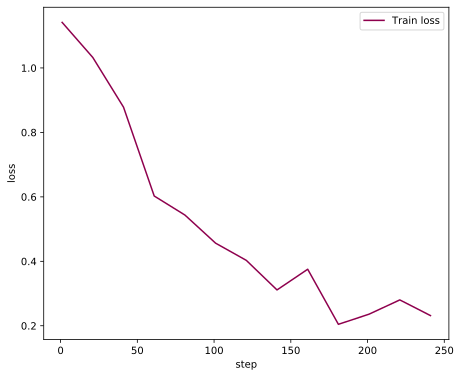

In [14]:
input_size = 4
output_size = 3
hidden_size = 6
# 定义模型
model = FeedForward(input_size, hidden_size, output_size)
# 定义损失函数
loss_fn = F.cross_entropy
# 定义优化器, 与之前的实验不同的是,momentum参数被修改
optimizer = torch.optim.Adam(model.parameters(), lr=0.02)
# 实例化辅助runner类
runner = Runner(model, optimizer, loss_fn)
# 模型训练
runner.train(train_loader, num_epochs=50, log_steps=10)
plot_training_loss_acc(runner, 'chapter7_24batchsize_Adam.pdf')

深度学习框架已经实了大部分的优化算法，它们都位于torch.optim中，所以需要我们理解其中每一个参数的作用。具体的细节可以参照Pytorch官方文档。

## 参数初始化

神经网络参数初始值的选取十分关键，关系到网络的优化效率和泛化能力。深度学习框架提供默认随机初始化,也允许我们创建自定义初始化方法，满足我们通过其他规则实现初始化权重。

这段代码定义了三个函数，用于初始化神经网络的权重和偏置,这些函数可以用于PyTorch的apply方法，对模型的所有层进行权重和偏置的初始化。例如，model.apply(init_xavier)会将模型model的所有线性层的权重进行Xavier初始化。

In [15]:
#这个函数用于将线性层的权重初始化为常数1，偏置初始化为0
def init_constant(m):
    if type(m) == nn.Linear:
        nn.init.constant_(m.weight, 1)
        nn.init.zeros_(m.bias)


#这个函数用于将线性层的权重初始化为Xavier初始化。Xavier初始化的目的是使得每一层的输出的方差不受输入节点数量的影响，从而避免在深度神经网络中出现梯度消失或梯度爆炸的问题
def init_xavier(m):
    if type(m) == nn.Linear:
        nn.init.xavier_uniform_(m.weight)
        
        
#这个函数用于将线性层的权重初始化为均值为0、标准差为0.01的正态分布，偏置初始化为0
def init_normal(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, mean=0, std=0.01)
        nn.init.zeros_(m.bias)


让我们用常数初始化网络参数，并打印出网络每一层的参数。你也可以测试另外两种初始化方式，但结果并不像常数初始化一样易懂。

In [16]:
net = FeedForward(4, 6, 3)
net.apply(init_constant)
net.fc1.weight.data
# net.fc2.weight.data

tensor([[1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.]])

## 批量规范化（Batch Normalization）

批量规范化应用于单个层（也可以应用到所有层），其原理如下：在每次训练迭代中，我们首先规范化输入，即通过减去其均值并除以其标准差，其中两者均基于当前小批量处理。 接下来，我们应用比例系数和比例偏移。 正是由于这个基于批量统计的标准化，才有了批量规范化的名称。

In [17]:
def batch_norm(X, gamma, beta, moving_mean, moving_var, eps, momentum):
    # 通过is_grad_enabled来判断当前模式是训练模式还是预测模式
    if not torch.is_grad_enabled():
        # 如果是在预测模式下，直接使用传入的移动平均所得的均值和方差
        X_hat = (X - moving_mean) / torch.sqrt(moving_var + eps)
    else:
        assert len(X.shape) in (2, 4)
        if len(X.shape) == 2:
            # 使用全连接层的情况，计算特征维上的均值和方差
            mean = X.mean(dim=0)
            var = ((X - mean) ** 2).mean(dim=0)
        else:
            # 使用二维卷积层的情况，计算通道维上（axis=1）的均值和方差。
            # 这里我们需要保持X的形状以便后面可以做广播运算
            mean = X.mean(dim=(0, 2, 3), keepdim=True)
            var = ((X - mean) ** 2).mean(dim=(0, 2, 3), keepdim=True)
        # 训练模式下，用当前的均值和方差做标准化
        X_hat = (X - mean) / torch.sqrt(var + eps)
        # 更新移动平均的均值和方差
        moving_mean = momentum * moving_mean + (1.0 - momentum) * mean
        moving_var = momentum * moving_var + (1.0 - momentum) * var
    Y = gamma * X_hat + beta  # 缩放和移位
    return Y, moving_mean.data, moving_var.data

In [18]:
class BatchNorm(nn.Module):
    # num_features：完全连接层的输出数量或卷积层的输出通道数。
    # num_dims：2表示全连接层，4表示卷积层
    def __init__(self, num_features, num_dims):
        super().__init__()
        if num_dims == 2:
            shape = (1, num_features)
        else:
            shape = (1, num_features, 1, 1)
        # 参与求梯度和迭代的拉伸和偏移参数，分别初始化成1和0
        self.gamma = nn.Parameter(torch.ones(shape))
        self.beta = nn.Parameter(torch.zeros(shape))
        # 非模型参数的变量初始化为0和1
        self.moving_mean = torch.zeros(shape)
        self.moving_var = torch.ones(shape)

    def forward(self, X):
        # 如果X不在内存上，将moving_mean和moving_var 复制到X所在显存上
        if self.moving_mean.device != X.device:
            self.moving_mean = self.moving_mean.to(X.device)
            self.moving_var = self.moving_var.to(X.device)
        # 保存更新过的moving_mean和moving_var
        Y, self.moving_mean, self.moving_var = batch_norm(
            X, self.gamma, self.beta, self.moving_mean,
            self.moving_var, eps=1e-5, momentum=0.9)
        return Y

我们利用cifar-10数据集训练一个带有批量规范化层的LeNet，并看一看它学到的参数。

In [19]:
import os

def read_csv_labels(fname):
    """读取fname来给标签字典返回一个文件名"""
    with open(fname, 'r') as f:
        # 跳过文件头行(列名)
        lines = f.readlines()[1:]
    tokens = [l.rstrip().split(',') for l in lines]
    return dict(((name, label) for name, label in tokens))

class CIFAR10Dataset(Dataset):
    def __init__(self, folder_path, fname):
        self.labels = read_csv_labels(os.path.join(folder_path, fname))
        self.folder_path = os.path.join(folder_path, 'train')
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        img = read_image(self.folder_path + '/' + str(idx+1) + '.png')
        label = self.labels[str(idx+1)]
        
        return img, torch.tensor(int(label))
    

In [20]:
batch_size = 20
# cifar10_tiny是卷积神经网络那节课的数据集的文件夹
train_data = CIFAR10Dataset('cifar10_tiny', 'trainLabels.csv')
train_iter = DataLoader(train_data, batch_size=batch_size)

In [21]:
class Runner(object):
    def __init__(self, model, optimizer, loss_fn, metric=None):
        self.model = model
        self.optimizer = optimizer
        self.loss_fn = loss_fn
        # 用于计算评价指标
        self.metric = metric
        
        # 记录训练过程中的评价指标变化
        self.dev_scores = []
        # 记录训练过程中的损失变化
        self.train_epoch_losses = []
        self.dev_losses = []
        # 记录全局最优评价指标
        self.best_score = 0
    def train(self, train_loader, dev_loader=None, **kwargs):
        # 将模型设置为训练模式，此时模型的参数会被更新
        self.model.train()
        
        num_epochs = kwargs.get('num_epochs', 0)
        log_steps = kwargs.get('log_steps', 100)
        save_path = kwargs.get('save_path','best_model.pth')
        eval_steps = kwargs.get('eval_steps', 0)
        # 运行的step数，不等于epoch数
        global_step = 0
        
        if eval_steps:
            if dev_loader is None:
                raise RuntimeError('Error: dev_loader can not be None!')
            if self.metric is None:
                raise RuntimeError('Error: Metric can not be None')
                
        # 遍历训练的轮数
        for epoch in range(num_epochs):
            total_loss = 0
            # 遍历数据集
            for step, data in enumerate(train_loader):
                x, y = data
                logits = self.model(x.float())
                loss = self.loss_fn(logits, y.long())
                total_loss += loss
                if step%log_steps == 0:
                    print(f'loss:{loss.item():.5f}')
                    
                loss.backward()
                self.optimizer.step()
                self.optimizer.zero_grad()
            # 每隔一定轮次进行一次验证，由eval_steps参数控制，可以采用不同的验证判断条件
            if eval_steps != 0 :
                if (epoch+1) % eval_steps ==  0:

                    dev_score, dev_loss = self.evaluate(dev_loader, global_step=global_step)
                    print(f'[Evalute] dev score:{dev_score:.5f}, dev loss:{dev_loss:.5f}')
                
                    if dev_score > self.best_score:
                        self.save_model(f'model_{epoch+1}.pth')
                    
                        print(f'[Evaluate]best accuracy performance has been updated: {self.best_score:.5f}-->{dev_score:.5f}')
                        self.best_score = dev_score
                    
                # 验证过程结束后，请记住将模型调回训练模式   
                    self.model.train()
            
            global_step += 1
            # 保存当前轮次训练损失的累计值
            train_loss = (total_loss/len(train_loader)).item()
            self.train_epoch_losses.append((global_step,train_loss))
        self.save_model(f'{save_path}.pth')   
        print('[Train] Train done')
        
    # 模型评价阶段
    def evaluate(self, dev_loader, **kwargs):
        assert self.metric is not None
        # 将模型设置为验证模式，此模式下，模型的参数不会更新
        self.model.eval()
        global_step = kwargs.get('global_step',-1)
        total_loss = 0
        self.metric.reset()
        
        for batch_id, data in enumerate(dev_loader):
            x, y = data
            logits = self.model(x.float())
            loss = self.loss_fn(logits, y.long()).item()
            total_loss += loss 
            self.metric.update(logits, y)
            
        dev_loss = (total_loss/len(dev_loader))
        self.dev_losses.append((global_step, dev_loss))
        dev_score = self.metric.accumulate()
        self.dev_scores.append(dev_score)
        return dev_score, dev_loss
    
    # 模型预测阶段，
    def predict(self, x, **kwargs):
        self.model.eval()
        logits = self.model(x)
        return logits
    
    # 保存模型的参数
    def save_model(self, save_path):
        torch.save(self.model.state_dict(), save_path)
        
    # 读取模型的参数
    def load_model(self, model_path):
        self.model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))


def plot_training_loss_acc(runner, fig_name, fig_size=(16, 6), sample_step=20, loss_legend_loc='upper right', acc_legend_loc='lower right',
                          train_color = '#8E004D', dev_color = '#E20079', fontsize='x-large', train_linestyle='-', dev_linestyle='--'):
    plt.figure(figsize=fig_size)
    plt.subplot(1,2,1)
    train_items = runner.train_epoch_losses[::sample_step]
    train_steps = [x[0] for x in train_items]
    train_losses = [x[1] for x in train_items]
    
    plt.plot(train_steps, train_losses, color=train_color, linestyle=train_linestyle, label='Train loss')
    if len(runner.dev_losses) > 0:
        dev_steps = [x[0] for x in runner.dev_losses]
        dev_losses = [x[1] for x in runner.dev_losses]
        plt.plot(dev_steps, dev_losses, color=dev_color, linestyle=dev_linestyle,label='dev loss')
    
    plt.ylabel('loss')
    plt.xlabel('step')
    plt.legend(loc=loss_legend_loc)
    if len(runner.dev_scores) > 0:
        plt.subplot(1,2,2)
        plt.plot(dev_steps, runner.dev_scores, color=dev_color, linestyle=dev_linestyle, label='dev accuracy')
        
        plt.ylabel('score')
        plt.xlabel('step')
        plt.legend(loc=acc_legend_loc)
    # 将绘制结果保存
    plt.savefig(fig_name)
    plt.show()


In [22]:
num_classes = 10
# 定义模型
net = nn.Sequential(
    nn.Conv2d(3, 6, kernel_size=5), BatchNorm(6, num_dims=4), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Conv2d(6, 16, kernel_size=5), BatchNorm(16, num_dims=4), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2), nn.Flatten(),
    nn.Linear(400, 120), BatchNorm(120, num_dims=2), nn.Sigmoid(),
    nn.Linear(120, 84), BatchNorm(84, num_dims=2), nn.Sigmoid(),
    nn.Linear(84, 10))
# 定义损失函数
loss_fn = F.cross_entropy
# 定义优化器
optimizer = torch.optim.SGD(net.parameters(), lr=0.1)

runner = Runner(net, optimizer, loss_fn, metric=None)
runner.train(train_iter, num_epochs=10, save_path='week_8')

loss:2.41395


loss:2.07201
loss:1.94783
loss:1.88785
loss:1.84667
loss:1.81052
loss:1.80249
loss:1.69758
loss:1.63439
loss:1.59859
[Train] Train done


In [23]:
# 第一个批量规范化层中学到的拉伸参数gamma和偏移参数beta
net[1].gamma.reshape((-1,)), net[1].beta.reshape((-1,))

(tensor([1.0285, 1.1475, 0.9355, 1.0073, 1.0540, 0.9219],
        grad_fn=<ReshapeAliasBackward0>),
 tensor([-0.0896,  0.3194, -0.2351,  0.1619, -0.1452, -0.0919],
        grad_fn=<ReshapeAliasBackward0>))

## 层规范化（作业）
<b>请参照层规范化的计算公式，实现层规范化的代码。</b>\
层规范化与批量规范化的区别是层规范化对一个中间层的所有神经元进行规范化，也就是对每个样本的所有特征进行规范化。

这段代码定义了一个名为LayerNorm的类，实现了层归一化（Layer Normalization）操作。这个类继承自PyTorch的nn.Module类。层归一化是一种常用的归一化技术，它在每一层的每一个样本上独立地进行归一化。这种归一化方式可以使得神经网络在训练过程中更加稳定，有助于加速训练过程和提高模型的泛化能力。

In [24]:
class LayerNorm(nn.Module):
    #初始化函数，接收三个参数：eps（防止除数为零的小数）、gamma（缩放因子）和beta（偏移因子）。这三个参数都是层归一化的超参数
    def __init__(self, eps=1e-7, gamma=1.0, beta=0.0):
        super().__init__
        self.gamma = torch.tensor(gamma)
        self.beta = torch.tensor(beta)
        self.eps = eps
    
    
    #前向传播函数，接收输入x，执行层归一化操作，并返回输出。
    #在这个函数中，首先计算输入x在最后一个维度上的均值和方差，然后使用这两个统计量对输入x进行归一化，最后使用缩放因子gamma和偏移因子beta对归一化后的结果进行缩放和偏移
    def forward(self, x):
        # x为规范化层的输入，请注意x的维度
        mean = x.mean(-1, keepdim=True)
        var = x.var(-1, keepdim=True)
        x_norm = (x - mean) / torch.sqrt(var + self.eps)
        output = self.gamma * x_norm + self.beta
        return output
    
    
